# Introduction

We want to study how melting transition in 2D systems can be mapped to networks

![Alt text](defects.gif)

In [1]:
import networkx as nx
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Useful functions
from scipy.spatial import distance_matrix

def read_data(path):
    data_array = []
    data_fis = []
    # Read in the data
    for fi in glob.glob(path + '/fi*'):
        # extract the density from the path name
        density, run = tuple(fi.split('/')[2].split('_'))
        density = float(density.split('fi')[1])
        #print(density, run)
        trj = glob.glob(fi + '/Trj/xyz.dump.*')[-1]
        #print(trj)
        data = np.loadtxt(trj, skiprows=9)
        
        data_array.append(data[:,[1,2]])
        data_fis.append(density)
    return data_array, data_fis

def smaller_sys(pos, edge):
    """Return the positions of the particles that are within the edge of the box"""
    return pos[(pos[:,0] < edge) & (pos[:,1] < edge)]

def create_graph(data_array, data_fis, density):
    """Create a graph from the distance matrix"""
    index = data_fis.index(density)
    dist = distance_matrix(data_array[index], data_array[index])
    
    dist_discret = np.where(dist <= 1.5, 1, 0)
    dist_nodiag = dist_discret - np.diag(np.diag(dist_discret))

    # delete the first and last row of the matrix
    dist_nodiag = np.delete(dist_nodiag, 0, axis=0)
    dist_nodiag = np.delete(dist_nodiag, -1, axis=0)
    # delete the first and last column of the matrix
    dist_nodiag = np.delete(dist_nodiag, 0, axis=1)
    dist_nodiag = np.delete(dist_nodiag, -1, axis=1)

    G = nx.from_numpy_array(dist_nodiag)
    return G

def reduce_all_confs(data_array, edge):
    new_data_array = []
    for conf in data_array:
        new_conf = smaller_sys(conf, edge)
        new_data_array.append(new_conf)
    return new_data_array


# Read and adjust data

In [3]:
path = 'ordered_128/Pe0/'
data_array, data_fis = read_data(path)

fi_set = set(data_fis)
print(sorted(fi_set))

[0.7, 0.702, 0.704, 0.705, 0.706, 0.708, 0.71, 0.712, 0.714, 0.715, 0.716, 0.718, 0.72, 0.722, 0.723, 0.724, 0.725, 0.726, 0.727, 0.728, 0.729, 0.73, 0.731, 0.732, 0.733, 0.734, 0.735, 0.736, 0.737, 0.738, 0.739, 0.74]


In [4]:
# reduce all the configurations 
new_data_array = reduce_all_confs(data_array, 100)
smaller_data_array = reduce_all_confs(data_array, 10)

# Data visualization

In order to create the adjacency matrix, we compute the distances between al pair of particles in the configurations, then we discretize the distance matrix with the threshold 1.5, and last we delete the diagonal to avoid self-contacts.

15.17021622865673
[21.78909  0.91919] [6.6315  0.30038]
15.17021622865673


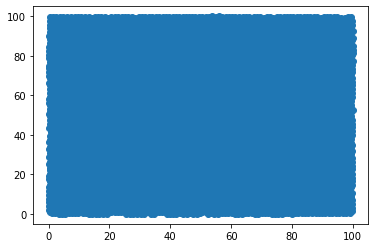

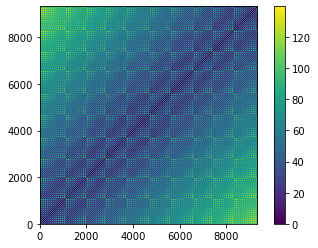

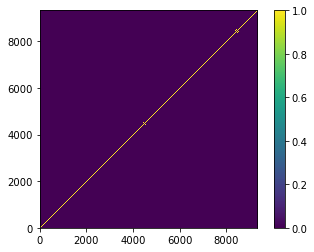

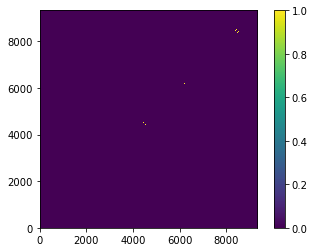

In [5]:
#plot a nice view of the distance matrix and of the configurations

density_analysis_array = [0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740] 


fig_conf, ax_conf = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
fig_dm, ax_dm = plt.subplots(figsize=(40,20), nrows=2, ncols=4)

for fi in density_analysis_array:
    index = data_fis.index(fi)
    dist = distance_matrix(new_data_array[index], new_data_array[index])
    dist_discret = np.where(dist <= 1.5, 1, 0)
    dist_nodiag = dist_discret - np.diag(np.diag(dist_discret))

    ax_conf.set_title('Density = {}'.format(fi))
    ax_dm.set_title('Density = {}'.format(fi))

    ax_conf.plot(smaller_data_array[index][:,0], smaller_data_array[index][:,1], 'o')
    ax_dm.imshow(dist, origin='lower', interpolation='nearest')
    


# Network Analysis

In [6]:
# other useful functions for analysis
import matplotlib 

# array of the density we want to analyze
density_analysis_array = [0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740] 
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(density_analysis_array)))

def graph_plotting(G, style=None):
    plt.clf()
    
    if style == 'circular':
        circ_pos = nx.circular_layout(G)
        nx.draw(G, pos=circ_pos, with_labels=True, node_size=5)
        plt.show()
        return None
    
    nx.draw(G, with_labels=False, font_weight='bold', node_size=5)
    plt.show()
    return None


def grade_analysis(G, verbose=False):
    '''Compute the degree distribution'''
    degree_sequence = np.array([d for n, d in G.degree()])  # degree sequence
    degree_hist, degree_bins = np.histogram(degree_sequence, bins=range(0, 12))
    if verbose:
        print("Avg degree: ", np.average(degree_sequence))
    return degree_hist, degree_bins

def betwenness_analysis(G):
    plt.clf()
    # compute betwenness centrality
    bet_cen = nx.betweenness_centrality(G)
    # plot betwenness centrality histogram
    plt.hist(list(bet_cen.values()), bins=50)
    plt.xlim(0,0.15)
    plt.ylim(0,35)
    plt.show()


## Clustering

The graph at density 0.705 is connected
The graph at density 0.71 is connected
The graph at density 0.715 is connected
The graph at density 0.72 is connected
The graph at density 0.725 is connected
The graph at density 0.73 is connected
The graph at density 0.735 is connected
The graph at density 0.74 is connected


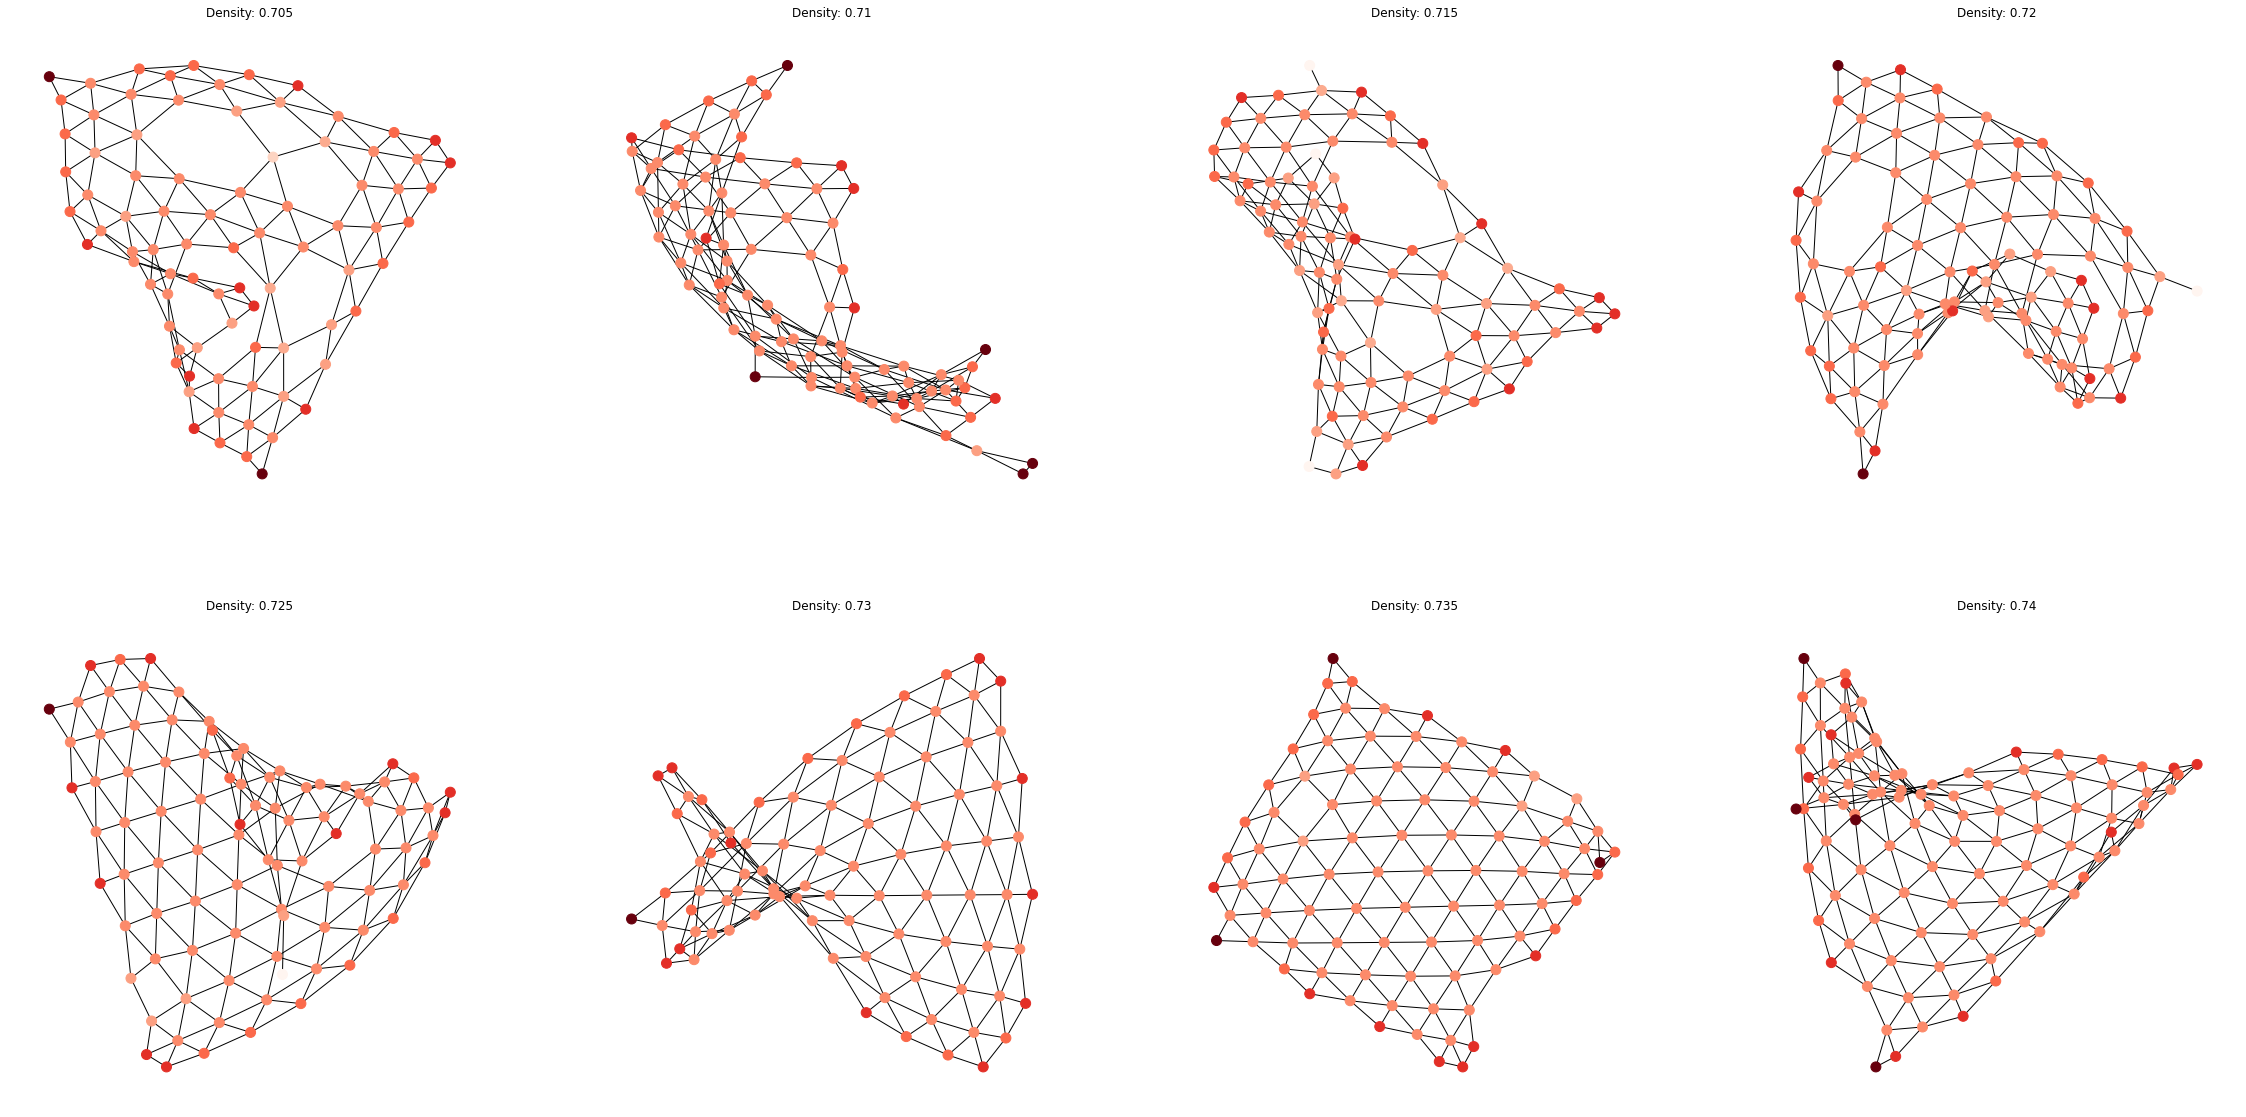

In [7]:

#shortest_path_avg = []
#diameter_avg = []
fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G = create_graph(new_data_array, data_fis, fi)
    if nx.is_connected(G):
        print(f'The graph at density {fi} is connected')
    G_small = create_graph(smaller_data_array, data_fis, fi)
    # select axis with index
    ax = axs.flat[density_analysis_array.index(fi)]
    # plot the graph
    clustering = nx.clustering(G_small)
    ax.set_title('Density: ' + str(fi))
    # plot circular graph

    nx.draw(G_small, with_labels=False, ax=ax, pos=nx.circular_layout(G_small),
            font_weight='bold', node_size=100, node_color=list(clustering.values()),
            cmap=plt.cm.Reds, vmin=0, vmax=1)
    #shortest_path_avg.append(nx.average_shortest_path_length(G_small))
    #diameter_avg.append(nx.diameter(G_small))


There is a passage from random graph to a graph with attachment probability p = 1 

## Averages

Text(0.5, 1.0, 'Transitivity')

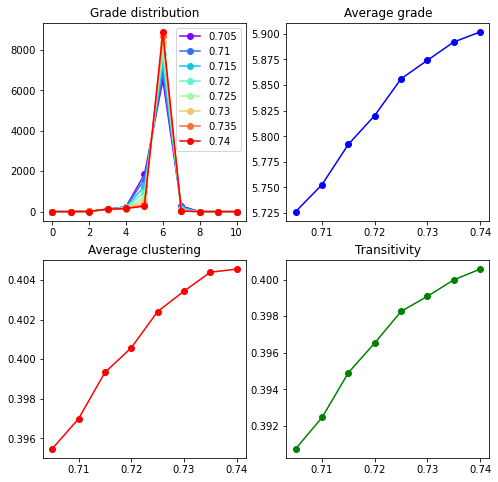

In [8]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)
grade_avg = []
clustering_avg = []
transitivity_avg = []
for fi in density_analysis_array:
    G = create_graph(new_data_array, data_fis, fi)
    grade_hist, grade_bins = grade_analysis(G, verbose=False)
    ax[0,0].plot(grade_bins[:-1], grade_hist, 'o-', label=fi, color=colors[density_analysis_array.index(fi)])
    # average of all the degrees
    grade_avg.append(np.average(np.array([d for n, d in G.degree()])))
    clustering_avg.append(nx.average_clustering(G))
    transitivity_avg.append(nx.transitivity(G))
ax[0,0].legend()

ax[0,1].plot(density_analysis_array, grade_avg, 'o-', color='blue')
ax[1,0].plot(density_analysis_array, clustering_avg, 'o-', color='red')
ax[1,1].plot(density_analysis_array, transitivity_avg, 'o-', color='green')
#ax[0,2].plot(density_analysis_array, shortest_path_avg, 'o-', color='orange')
#ax[1,2].plot(density_analysis_array, diameter_avg, 'o-', color='purple')

ax[0,1].vlines(0.726, 0, 10, color='black', linestyle='--')
ax[1,0].vlines(0.726, 0, 1, color='black', linestyle='--')
ax[1,1].vlines(0.726, 0, 1, color='black', linestyle='--')

ax[0,0].set_title('Grade distribution')
ax[0,1].set_title('Average grade')
ax[1,0].set_title('Average clustering')
ax[1,1].set_title('Transitivity')
#ax[0,2].set_title('Average shortest path')
#ax[1,2].set_title('Diameter')


## Betwenees Centrality 

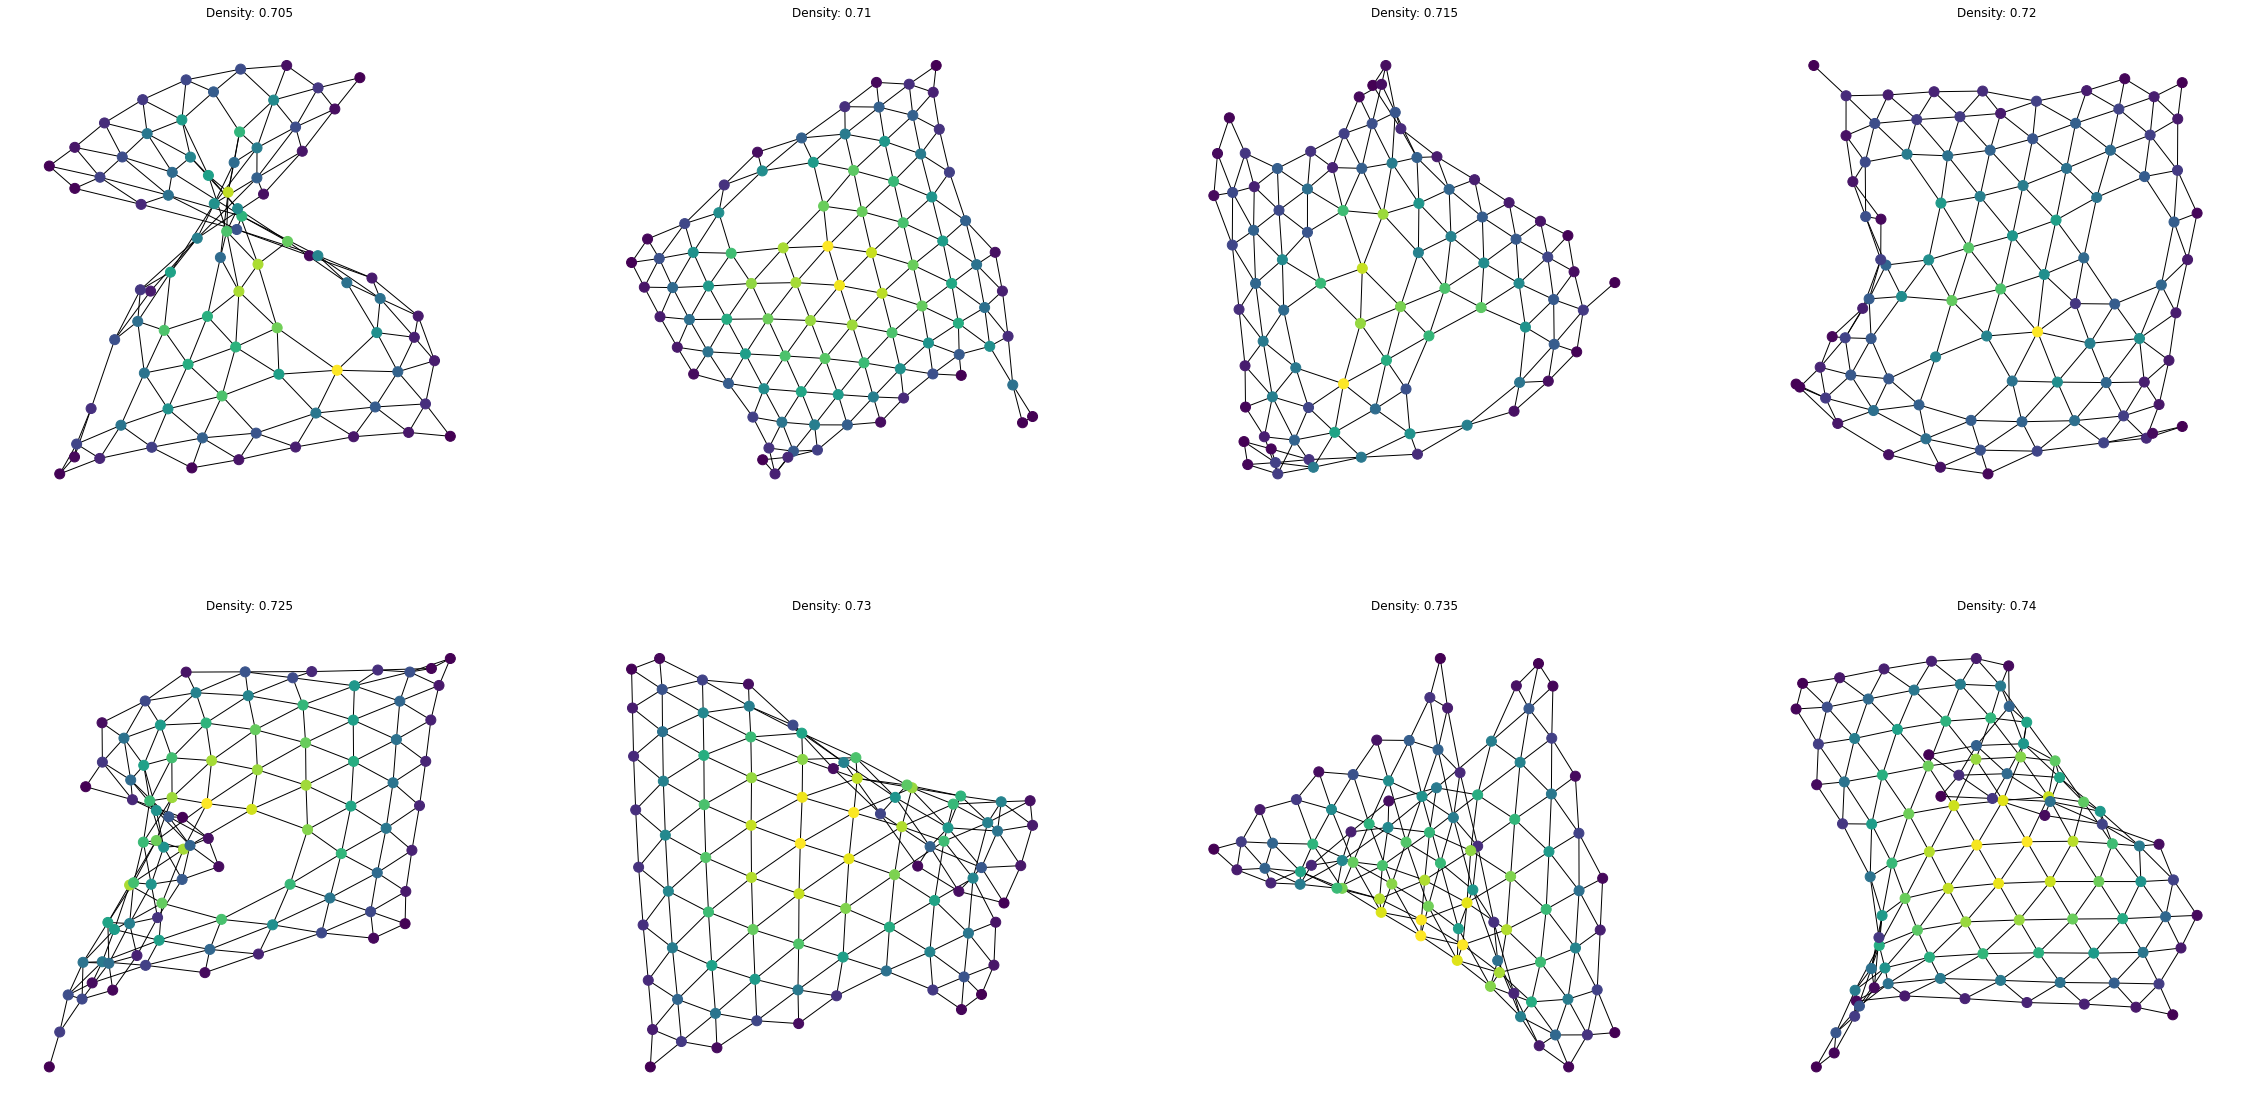

In [9]:

fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G_small = create_graph(smaller_data_array, data_fis, fi)
    ax = axs.flat[density_analysis_array.index(fi)]
    betwenness_centr = nx.betweenness_centrality(G_small)
    betw_hist, betw_bins = np.histogram(list(betwenness_centr.values()), bins='auto')
    #ax.set_xrange(0,0.2)
    ax.set_title('Density: ' + str(fi))
    #ax.set_yscale('log')
    #ax.bar(betw_bins[:-1], betw_hist, width=0.01, color=colors[density_analysis_array.index(fi)],alpha=0.5)
    nx.draw(G_small, with_labels=False, ax=ax,  
        font_weight='bold', node_size=100, node_color=list(betwenness_centr.values()),
        cmap=plt.cm.viridis, vmin=np.min(list(betwenness_centr.values())), vmax=np.max(list(betwenness_centr.values())))
#fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1)), ax=axs[:, 3], shrink=0.6, cmap=plt.cm.viridis)



## Closeness centrality

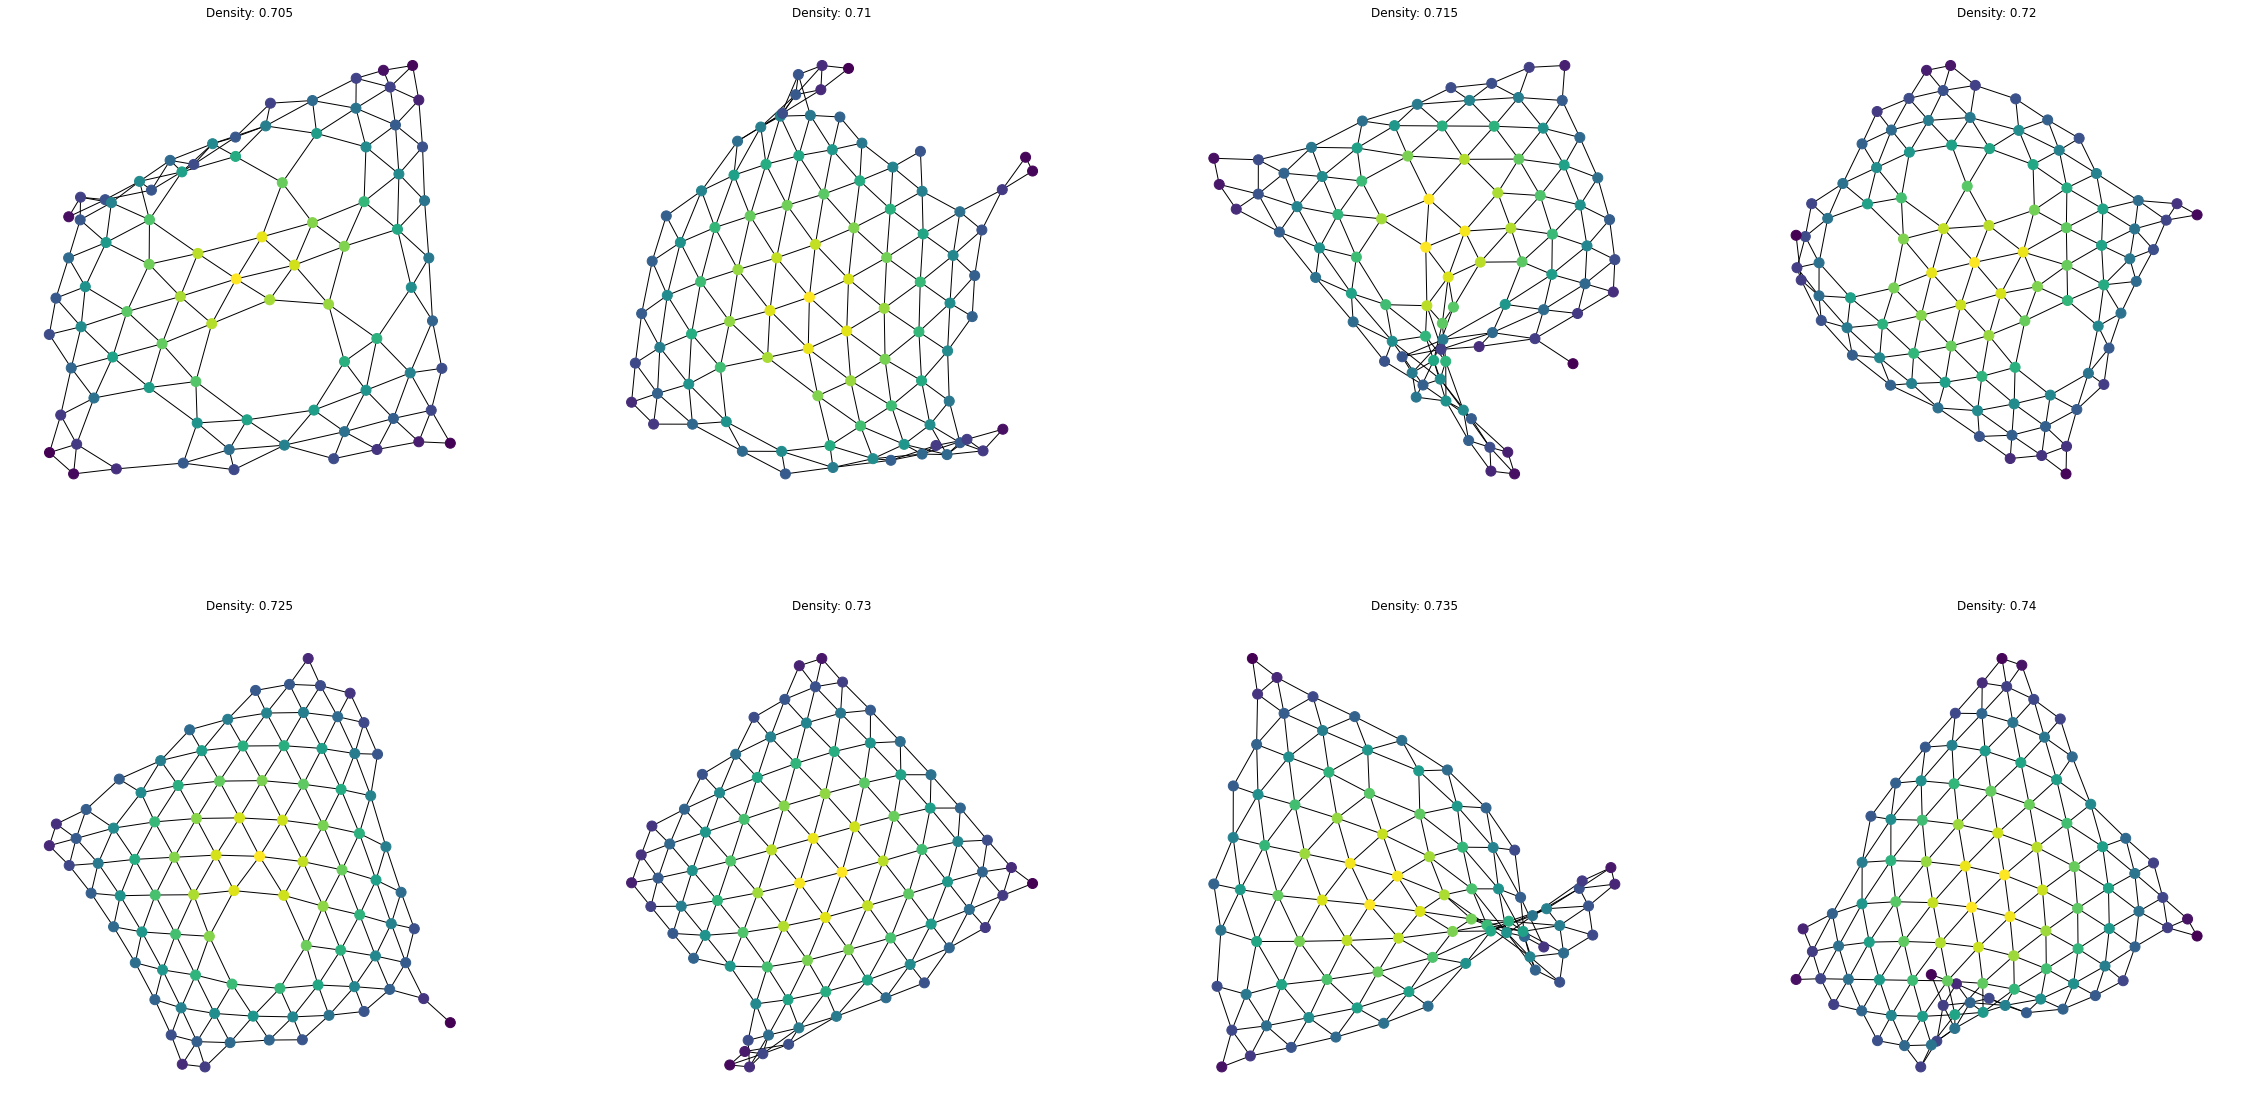

In [10]:

fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G_small = create_graph(smaller_data_array, data_fis, fi)
    ax = axs.flat[density_analysis_array.index(fi)]
    closeness_centr = nx.closeness_centrality(G_small)
    betw_hist, betw_bins = np.histogram(list(closeness_centr.values()), bins='auto')
    #ax.set_xrange(0,0.2)
    ax.set_title('Density: ' + str(fi))
    #ax.set_yscale('log')
    #ax.bar(betw_bins[:-1], betw_hist, width=0.01, color=colors[density_analysis_array.index(fi)],alpha=0.5)
    nx.draw(G_small, with_labels=False, ax=ax, 
        font_weight='bold', node_size=100, node_color=list(closeness_centr.values()),
        cmap=plt.cm.viridis, vmin=np.min(list(closeness_centr.values())), vmax=np.max(list(closeness_centr.values())))
#fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1)), ax=axs[:, 3], shrink=0.6, cmap=plt.cm.viridis)


# Future developements